In [ ]:
# == Hyperparameter configuration ==

# Official scored labels Physionet 2021: https://github.com/physionetchallenges/evaluation-2021/blob/main/dx_mapping_scored.csv

# 0 = 426783006 -> sinus rhythm (SR)
# 1 = 164889003 -> atrial fibrillation (AF)
# 2 = 164890007 -> atrial flutter (AFL)
# 3 = 284470004 or 63593006 -> premature atrial contraction (PAC) or supraventricular premature beats (SVPB)
# 4 = 427172004 or 17338001 -> premature ventricular contractions (PVC), ventricular premature beats (VPB)
# 5 = 6374002 -> bundle branch block (BBB)
# 6 = 426627000 -> bradycardia (Brady)
# 7 = 733534002 or 164909002 -> complete left bundle branch block (CLBBB), left bundle branch block (LBBB)
# 8 = 713427006 or 59118001 -> complete right bundle branch block (CRBBB), right bundle branch block (RBBB)
# 9 = 270492004 -> 1st degree av block (IAVB)
# 10 = 713426002 -> incomplete right bundle branch block (IRBBB)
# 11 = 39732003 -> left axis deviation (LAD)
# 12 = 445118002 -> left anterior fascicular block (LAnFB)
# 13 = 251146004 -> low qrs voltages (LQRSV)
# 14 = 698252002 -> nonspecific intraventricular conduction disorder (NSIVCB)
# 15 = 10370003 -> pacing rhythm (PR)
# 16 = 365413008 -> poor R wave Progression (PRWP)
# 17 = 164947007 -> prolonged pr interval (LPR)
# 18 = 111975006 -> prolonged qt interval (LQT)
# 19 = 164917005 -> qwave abnormal (QAb)
# 20 = 47665007 -> right axis deviation (RAD)
# 21 = 427393009 -> sinus arrhythmia (SA)
# 22 = 426177001 -> sinus bradycardia (SB)
# 23 = 427084000 -> sinus tachycardia (STach)
# 24 = 164934002 -> t wave abnormal (TAb)
# 25 = 59931005 -> t wave inversion (TInv)

VALID_LABELS = set(
    [
        "164889003",
        "164890007",
        "6374002",
        "426627000",
        "733534002",
        "713427006",
        "270492004",
        "713426002",
        "39732003",
        "445118002",
        "164909002",
        "251146004",
        "698252002",
        "426783006",
        "284470004",
        "10370003",
        "365413008",
        "427172004",
        "164947007",
        "111975006",
        "164917005",
        "47665007",
        "59118001",
        "427393009",
        "426177001",
        "427084000",
        "63593006",
        "164934002",
        "59931005",
        "17338001",
    ]
)
# VALID_LABELS = set(["426783006", "164889003", "164890007", "284470004", "427172004"]) # SR, AF, AFL, PAC, PVC
NUM_CLASSES =  26

CLASS_BALANCE = 6000 # imblearn undersampling & imblearn oversampling
TEST_BALANCE = 100 # imblearn undersampling
TRAIN_TEST_SPLIT = 0.8
VALIDATION_SPLIT = 0.25

EPOCHS = 500
LEARNING_RATE = 0.001
BATCH_SIZE = 128

In [ ]:
# == Check if GPU is available ==

!nvidia-smi

Sun Jun 16 22:45:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8              17W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# == Install requirements ==

!pip install google-colab
!pip install tensorflow keras numpy
!pip install h5py tqdm
!pip install pandas scipy imblearn

In [ ]:
# == Import requirements ==

import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
import os
import h5py
from tqdm import tqdm
import pandas as pd
from collections import Counter

import random
import scipy
from scipy.signal import butter, lfilter
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

In [ ]:
# Preprocess functions

def pad_or_truncate_ecg(ecg: list, max_samples: int) -> list:
    try:
        padded_or_truncated_ecg = ecg[:max_samples] + [0] * (max_samples - len(ecg))
    except Exception as e:
        print("Fail: padding", e)
    return padded_or_truncated_ecg

def resample_ecg(ecg: list, resample: int):
    new_ecg = scipy.signal.resample(
        ecg, resample, t=None, axis=0, window=None, domain="time"
    )
    return list(new_ecg)

def normalize_to_minus11(ecg: list):
    max_val = max(ecg)
    min_val = min(ecg)
    # Handle the case where max_val and min_val are the same (to avoid division by zero)
    if max_val == min_val:
        return [0 for _ in ecg]
    normalized_values = [2 * (x - min_val) / (max_val - min_val) - 1 for x in ecg]
    return normalized_values

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype="band")
    return b, a

def butter_bandpass_filter(ecg: list, lowcut: float, highcut: float, sampling_rate: int, order: int =4):
    b, a = butter_bandpass(lowcut, highcut, sampling_rate, order=order)
    y = lfilter(b, a, ecg)
    return y

def split_list_into_n_sublists(lst, n):
    k, m = divmod(len(lst), n)
    return [lst[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]

In [ ]:
# == Mount drive ==

# https://drive.google.com/drive/folders/1L_gOMrkygu2N0k97COYuVrmE-AwEEMoQ

drive.mount('/content/drive')
path = "/content/drive/My Drive/Master Thesis/Datasets"
!ls "/content/drive/My Drive/Master Thesis/Datasets"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
codes_SNOMED.csv  physionet2017_references.csv	physionet2021_references.csv
physionet2017.h5  physionet2021.h5		prepared


In [ ]:
# == Load all Physionet2021 ECGs and their IDs to a dictionary X_dict ==

X_dict = {}
Y_dict = {}

h5file = h5py.File(os.path.join(path, "prepared/physionet2021_scoredLabels.h5"), "r")
IDs = list(h5file.keys())
pbar = tqdm(total=len(IDs), desc="Load ECG data", position=0, leave=True)
for key in IDs:
    X_dict[key] = list(h5file[key][0])
    pbar.update(1)

# == Load all labels and their IDs to a dictionary Y_dict (some ECGs can have multiple labels) ==

labels_df = pd.read_csv(os.path.join(path, "physionet2021_references.csv"), sep=";")
pbar = tqdm(total=len(labels_df), desc="Load ECG labels", position=0, leave=True)
for _, row in labels_df.iterrows():
    Y_dict[row["id"]] = row["labels"].split(",")
    pbar.update(1)

del IDs, h5file

Load ECG labels:  99%|█████████▉| 87658/88252 [00:08<00:00, 19367.07it/s]

In [ ]:
# == Map scored labels to ECGs and create three lists (X: ECGs, Y: labels, Z: IDs) ==

X = []
Y = []
Z = []

for patient_id in tqdm(Y_dict, desc="Map labels to ECGs", position=0, leave=True):
    for label in Y_dict[patient_id]:
        try:
            if label in VALID_LABELS:
              X.append(X_dict[patient_id])
              Y.append(str(label))
              Z.append(str(patient_id))
        except:
            pass

del X_dict, Y_dict

Map labels to ECGs: 100%|██████████| 88252/88252 [00:00<00:00, 503338.61it/s]


In [ ]:
# == Map labels to numerical values ==

# Official scored labels Physionet 2021: https://github.com/physionetchallenges/evaluation-2021/blob/main/dx_mapping_scored.csv

Y = [0 if x == "426783006" else x for x in Y] # sinus rhythm (SR)
Y = [1 if x == "164889003" else x for x in Y] # atrial fibrillation (AF)
Y = [2 if x == "164890007" else x for x in Y] # atrial flutter (AFL)
Y = [3 if x == "284470004" or x == "63593006" else x for x in Y] # premature atrial contraction (PAC), supraventricular premature beats (SVPB)
Y = [4 if x == "427172004" or x == "17338001" else x for x in Y] # premature ventricular contractions (PVC), ventricular premature beats (VPB)
Y = [5 if x == "6374002" else x for x in Y] # bundle branch block (BBB)
Y = [6 if x == "426627000" else x for x in Y] # bradycardia (Brady)
Y = [7 if x == "733534002" or x == "164909002" else x for x in Y] # complete left bundle branch block (CLBBB), left bundle branch block (LBBB)
Y = [8 if x == "713427006" or x == "59118001" else x for x in Y] # complete right bundle branch block (CRBBB), right bundle branch block (RBBB)
Y = [9 if x == "270492004" else x for x in Y] # 1st degree av block (IAVB)
Y = [10 if x == "713426002" else x for x in Y] # incomplete right bundle branch block (IRBBB)
Y = [11 if x == "39732003" else x for x in Y] # left axis deviation (LAD)
Y = [12 if x == "445118002" else x for x in Y] # left anterior fascicular block (LAnFB)
Y = [13 if x == "251146004" else x for x in Y] # low qrs voltages (LQRSV)
Y = [14 if x == "698252002" else x for x in Y] # nonspecific intraventricular conduction disorder (NSIVCB)
Y = [15 if x == "10370003" else x for x in Y] # pacing rhythm (PR)
Y = [16 if x == "365413008" else x for x in Y] # poor R wave Progression (PRWP)
Y = [17 if x == "164947007" else x for x in Y] # prolonged pr interval (LPR)
Y = [18 if x == "111975006" else x for x in Y] # prolonged qt interval (LQT)
Y = [19 if x == "164917005" else x for x in Y] # qwave abnormal (QAb)
Y = [20 if x == "47665007" else x for x in Y] # right axis deviation (RAD)
Y = [21 if x == "427393009" else x for x in Y] # sinus arrhythmia (SA)
Y = [22 if x == "426177001" else x for x in Y] # sinus bradycardia (SB)
Y = [23 if x == "427084000" else x for x in Y] # sinus tachycardia (STach)
Y = [24 if x == "164934002" else x for x in Y] # t wave abnormal (TAb)
Y = [25 if x == "59931005" else x for x in Y] # t wave inversion (TInv)

In [ ]:
# == Preprocess ECGs ==

pbar = tqdm(total=len(X), desc="Preprocess ECGs", position=0, leave=True)
for index, _ in enumerate(X):
    X[index] = pad_or_truncate_ecg(ecg=X[index], max_samples=5000)
    X[index] = resample_ecg(ecg=X[index], resample=2000)
    X[index] = normalize_to_minus11(ecg=X[index])
    X[index] = butter_bandpass_filter(ecg=X[index], lowcut=0.3, highcut=21.0, sampling_rate=200)
    pbar.update(1)

Preprocess ECGs: 100%|█████████▉| 129333/129357 [04:23<00:00, 387.22it/s]

In [ ]:
# == Split train-test sets by patients if train-test splits files are given ==

if os.path.exists("trainset_patient_ids.txt") and os.path.exists("testset_patient_ids.txt"):
    f = open("trainset_patient_ids.txt", "r", encoding="utf-8")
    trainset_patient_ids = f.readlines()
    f.close()
    f = open("testset_patient_ids.txt", "r", encoding="utf-8")
    testset_patient_ids = f.readlines()
    f.close()
    trainset_patient_ids = list(map(lambda x: x.replace("\n", ""), trainset_patient_ids))
    testset_patient_ids = list(map(lambda x: x.replace("\n", ""), testset_patient_ids))
    trainset_patient_ids = set(trainset_patient_ids)
    testset_patient_ids = set(testset_patient_ids)
    X_train = []
    Y_train = []
    Z_train = []
    X_test = []
    Y_test = []
    Z_test = []
    for sample in zip(X, Y, Z):
        if sample[2] in trainset_patient_ids:
            X_train.append(sample[0])
            Y_train.append(sample[1])
            Z_train.append(sample[2])
        elif sample[2] in testset_patient_ids:
            X_test.append(sample[0])
            Y_test.append(sample[1])
            Z_test.append(sample[2])
    print(len(X_train), len(X_test))
    del X, Y, Z

92072 37285


In [ ]:
# == Split data train-test sets by patients ==

if not os.path.exists("trainset_patient_ids.txt") and not os.path.exists("testset_patient_ids.txt"):
    bins = []
    for x in range(NUM_CLASSES):
        bins.append([])

    # Create num_classes bins (1 bin = 1 class)
    for sample in zip(X, Y, Z):
        bins[sample[1]].append([sample[0], sample[1], sample[2]])

    # Create train-test bins (e.g. TRAIN_TEST_SPLIT = 80%-20%)
    train_bins = []
    test_bins = []
    for x in range(NUM_CLASSES):
        train_bins.append([])
        test_bins.append([])
    for index, bin in enumerate(bins):
        split_index = int(len(bin) * TRAIN_TEST_SPLIT)
        train_bins[index] = bin[:split_index]
        test_bins[index] = bin[split_index:]

    # Create test set (sort bins by occurence of labels descending before adding to train set because of minor classes and multiple labels and add if patient id is not in train set)
    X_test = []
    Y_test = []
    Z_test = []
    id_already_in_x_test = set()
    test_bins.sort(key=lambda x: len(x))
    for bin in test_bins:
        for sample in bin:
            if sample[2] not in id_already_in_x_test:
                id_already_in_x_test.add(sample[2])
                X_test.append(sample[0])
                Y_test.append(sample[1])
                Z_test.append(sample[2])

    # Create train set (sort bins by occurence of labels descending before adding to train set because of minor classes and multiple labels and add if patient id is not in train (split by patients) or test set (multiple labels in test set would bias the evaluation) already)
    X_train = []
    Y_train = []
    Z_train = []
    id_already_in_x_train = set()
    train_bins.sort(key=lambda x: len(x))
    for bin in train_bins:
        for sample in bin:
            if sample[2] not in id_already_in_x_train and sample[2] not in id_already_in_x_test:
                id_already_in_x_train.add(sample[2])
                X_train.append(sample[0])
                Y_train.append(sample[1])
                Z_train.append(sample[2])

    # Write train and test patient ids to file
    id_already_in_x_train_list = list(id_already_in_x_train)
    id_already_in_x_train_list = list(map(lambda x: str(x) + "\n", id_already_in_x_train_list))
    id_already_in_x_test_list = list(id_already_in_x_test)
    id_already_in_x_test_list = list(map(lambda x: str(x) + "\n", id_already_in_x_test_list))
    with open('trainset_patient_ids.txt', 'w', encoding='utf-8') as file:
        file.writelines(id_already_in_x_train_list)
    with open('testset_patient_ids.txt', 'w', encoding='utf-8') as file:
        file.writelines(id_already_in_x_test_list)
    del X, Y, Z

In [ ]:
print(Counter(Y_train))
print(Counter(Y_test))

Counter({0: 19812, 22: 14985, 24: 7824, 23: 7566, 2: 6699, 11: 4145, 1: 3624, 8: 3595, 21: 3002, 25: 2986, 9: 2558, 3: 2433, 4: 1480, 18: 1457, 19: 1376, 12: 1163, 13: 1154, 10: 1153, 15: 1142, 14: 959, 7: 870, 20: 825, 16: 494, 5: 404, 6: 232, 17: 134})
Counter({0: 9159, 22: 3933, 24: 3892, 11: 3486, 23: 2091, 2: 1675, 1: 1631, 8: 1235, 12: 1023, 25: 1003, 9: 976, 3: 832, 14: 809, 21: 788, 10: 704, 19: 700, 7: 619, 4: 458, 20: 455, 18: 450, 13: 445, 15: 338, 17: 258, 16: 144, 5: 118, 6: 63})


In [ ]:
# == Balance data ==

# Trainset

count_train = Counter(Y_train)

undersampling_strategy = {}
oversampling_strategy = {}
for i in count_train:
    if count_train[i] > CLASS_BALANCE:
        undersampling_strategy[i] = CLASS_BALANCE
    elif count_train[i] <= CLASS_BALANCE:
        oversampling_strategy[i] = CLASS_BALANCE
print(f"Trainset undersampling_strategy: {undersampling_strategy}")
print(f"Trainset oversampling_strategy: {oversampling_strategy}")

under = RandomUnderSampler(sampling_strategy=undersampling_strategy)
over = RandomOverSampler(sampling_strategy=oversampling_strategy)
steps = [("u", under), ("o", over)]
pipeline = Pipeline(steps=steps)
X_train_balanced, Y_train_balanced = pipeline.fit_resample(X_train, Y_train)

count_train_balanced = Counter(Y_train_balanced)

# Testset

count_test = Counter(Y_test)

# min_key = min(count_test, key=count_test.get)
# min_value = count_test[min_key]

undersampling_strategy = {}
for i in count_test:
    if count_test[i] > TEST_BALANCE:
        undersampling_strategy[i] = TEST_BALANCE

print(f"Testset undersampling_strategy: {undersampling_strategy}")

under = RandomUnderSampler(sampling_strategy=undersampling_strategy)
steps = [("u", under)]
pipeline = Pipeline(steps=steps)
X_test_balanced, Y_test_balanced = pipeline.fit_resample(X_test, Y_test)

count_test_balanced = Counter(Y_test_balanced)

print(f"Trainset: {count_train}")
print(f"Testset: {count_test}")
print(f"Trainset balanced: {count_train_balanced}")
print(f"Testset balanced: {count_test_balanced}")

Trainset undersampling_strategy: {0: 6000, 23: 6000, 24: 6000, 2: 6000, 22: 6000}
Trainset oversampling_strategy: {12: 6000, 25: 6000, 13: 6000, 16: 6000, 19: 6000, 5: 6000, 18: 6000, 14: 6000, 21: 6000, 6: 6000, 9: 6000, 8: 6000, 11: 6000, 3: 6000, 4: 6000, 20: 6000, 7: 6000, 15: 6000, 10: 6000, 17: 6000, 1: 6000}


Preprocess ECGs: 100%|██████████| 129357/129357 [04:35<00:00, 387.22it/s]

Testset undersampling_strategy: {2: 100, 8: 100, 24: 100, 5: 100, 25: 100, 12: 100, 19: 100, 16: 100, 7: 100, 10: 100, 20: 100, 11: 100, 14: 100, 15: 100, 13: 100, 21: 100, 18: 100, 4: 100, 23: 100, 0: 100, 3: 100, 17: 100, 22: 100, 9: 100, 1: 100}
Trainset: Counter({0: 19812, 22: 14985, 24: 7824, 23: 7566, 2: 6699, 11: 4145, 1: 3624, 8: 3595, 21: 3002, 25: 2986, 9: 2558, 3: 2433, 4: 1480, 18: 1457, 19: 1376, 12: 1163, 13: 1154, 10: 1153, 15: 1142, 14: 959, 7: 870, 20: 825, 16: 494, 5: 404, 6: 232, 17: 134})
Testset: Counter({0: 9159, 22: 3933, 24: 3892, 11: 3486, 23: 2091, 2: 1675, 1: 1631, 8: 1235, 12: 1023, 25: 1003, 9: 976, 3: 832, 14: 809, 21: 788, 10: 704, 19: 700, 7: 619, 4: 458, 20: 455, 18: 450, 13: 445, 15: 338, 17: 258, 16: 144, 5: 118, 6: 63})
Trainset balanced: Counter({0: 6000, 1: 6000, 2: 6000, 3: 6000, 4: 6000, 5: 6000, 6: 6000, 7: 6000, 8: 6000, 9: 6000, 10: 6000, 11: 6000, 12: 6000, 13: 6000, 14: 6000, 15: 6000, 16: 6000, 17: 6000, 18: 6000, 19: 6000, 20: 6000, 21: 60

In [ ]:
# == Shuffle data, convert to numpy lists and reshape ==

# Shuffle data

combined = list(zip(X_train, Y_train))
random.shuffle(combined)
X_train, Y_train = zip(*combined)
X_train = list(X_train)
Y_train = list(Y_train)

combined = list(zip(X_test, Y_test))
random.shuffle(combined)
X_test, Y_test = zip(*combined)
X_test = list(X_test)
Y_test = list(Y_test)

combined = list(zip(X_train_balanced, Y_train_balanced))
random.shuffle(combined)
X_train_balanced, Y_train_balanced = zip(*combined)
X_train_balanced = list(X_train_balanced)
Y_train_balanced = list(Y_train_balanced)

combined = list(zip(X_test_balanced, Y_test_balanced))
random.shuffle(combined)
X_test_balanced, Y_test_balanced = zip(*combined)
X_test_balanced = list(X_test_balanced)
Y_test_balanced = list(Y_test_balanced)

print(f"Y_train: {Y_train[:50]}")
print(f"Y_test: {Y_test[:50]}")
print(f"Y_train_balanced: {Y_train_balanced[:50]}")
print(f"Y_test_balanced: {Y_test_balanced[:50]}")

# Convert to numpy lists

Y_train = np.array(Y_train)
Y_test = np.array(Y_test)
Y_train_balanced = np.array(Y_train_balanced)
Y_test_balanced = np.array(Y_test_balanced)

for index, x in enumerate(X_train):
    X_train[index] = np.array(x)
X_train = np.array(X_train)

for index, x in enumerate(X_test):
    X_test[index] = np.array(x)
X_test = np.array(X_test)

for index, x in enumerate(X_train_balanced):
    X_train_balanced[index] = np.array(x)
X_train_balanced = np.array(X_train_balanced)

for index, x in enumerate(X_test_balanced):
    X_test_balanced[index] = np.array(x)
X_test_balanced = np.array(X_test_balanced)

# Reshape

X_train = X_train.reshape((-1, 2000, 1))
X_test = X_test.reshape((-1, 2000, 1))
X_train_balanced = X_train_balanced.reshape((-1, 2000, 1))
X_test_balanced = X_test_balanced.reshape((-1, 2000, 1))

Y_train: [24, 23, 19, 0, 15, 24, 0, 23, 23, 25, 22, 8, 22, 22, 0, 19, 22, 23, 22, 0, 22, 8, 8, 0, 8, 3, 4, 0, 24, 0, 22, 0, 23, 22, 23, 24, 11, 8, 12, 24, 0, 24, 4, 10, 1, 9, 24, 8, 22, 0]
Y_test: [23, 8, 0, 3, 0, 11, 20, 18, 11, 0, 21, 22, 0, 23, 0, 24, 24, 24, 0, 23, 24, 0, 24, 19, 15, 22, 9, 11, 24, 0, 11, 0, 1, 0, 2, 24, 22, 0, 24, 8, 8, 15, 0, 12, 0, 0, 15, 22, 11, 1]
Y_train_balanced: [10, 13, 25, 25, 13, 3, 11, 16, 5, 15, 18, 13, 17, 7, 4, 25, 17, 22, 24, 2, 6, 2, 20, 25, 7, 11, 18, 3, 4, 17, 18, 25, 16, 1, 6, 6, 5, 10, 19, 14, 3, 16, 17, 11, 7, 20, 1, 19, 17, 11]
Y_test_balanced: [21, 17, 25, 17, 16, 12, 10, 22, 1, 18, 19, 4, 15, 17, 18, 3, 7, 19, 17, 14, 19, 1, 3, 20, 20, 22, 13, 5, 8, 19, 4, 0, 9, 5, 7, 18, 2, 8, 20, 23, 24, 8, 2, 0, 19, 17, 13, 1, 10, 24]


In [ ]:
# == A-B-testing models ==

# Model A: Residual_CNN_1lead
def conv(i, filters=16, kernel_size=9, strides=1):
    i = keras.layers.Conv1D(
        filters=filters, kernel_size=kernel_size, strides=strides, padding="same"
    )(i)
    i = keras.layers.BatchNormalization()(i)
    i = keras.layers.LeakyReLU()(i)
    i = keras.layers.SpatialDropout1D(0.35)(i)
    return i
def residual_unit(x, filters, layers=3):
    inp = x
    for i in range(layers):
        x = conv(x, filters)
    return keras.layers.add([x, inp])
def conv_block(x, filters, strides):
    x = conv(x, filters)
    x = residual_unit(x, filters)
    if strides > 1:
        x = keras.layers.AveragePooling1D(strides, strides)(x)
    return x
def build_model_A(input_shape, num_classes):
    inp = keras.layers.Input(input_shape)
    x = inp
    x = conv_block(x, 16, 4)
    x = conv_block(x, 16, 4)
    x = conv_block(x, 32, 4)
    x = conv_block(x, 32, 4)
    x = keras.layers.Masking(mask_value=0)(x)
    x = keras.layers.GRU(128, recurrent_dropout=0.35)(x)
    x = keras.layers.Dense(num_classes, activation="softmax")(x)
    model = keras.models.Model(inp, x)
    return model

# Model B: CNN_Transformer_1lead
def build_model_B(num_classes, input_shape):
    # input_shape = (2000, 1)  # Each sample has 2000 timesteps and 1 feature per timestep
    input_layer = keras.layers.Input(input_shape)

    # Masking for padded/truncated data
    i = keras.layers.Masking(mask_value=0)(input_layer)
    # Conv1
    i = keras.layers.Conv1D(filters=16, kernel_size=9, strides=1, padding="same")(i)
    i = keras.layers.BatchNormalization()(i)
    i = keras.layers.ReLU()(i)
    i = keras.layers.SpatialDropout1D(0.1)(i)
    i = keras.layers.AveragePooling1D(2)(i)
    # Conv2
    i = keras.layers.Conv1D(filters=32, kernel_size=9, strides=1, padding="same")(i)
    i = keras.layers.BatchNormalization()(i)
    i = keras.layers.ReLU()(i)
    i = keras.layers.SpatialDropout1D(0.1)(i)
    i = keras.layers.AveragePooling1D(2)(i)
    # Conv3
    i = keras.layers.Conv1D(filters=64, kernel_size=9, strides=1, padding="same")(i)
    i = keras.layers.BatchNormalization()(i)
    i = keras.layers.ReLU()(i)
    i = keras.layers.SpatialDropout1D(0.1)(i)
    i = keras.layers.AveragePooling1D(2)(i)
    # Channel Average Pooling and Reshaping
    i = keras.layers.GlobalAveragePooling1D(data_format="channels_first")(i)
    i = keras.layers.Reshape((5, 50))(i)
    # Encoder block/Attention mechanisms
    i = keras.layers.MultiHeadAttention(num_heads=10, key_dim=5, dropout=0.3)(i, i)
    # i = keras.layers.MultiHeadAttention(num_heads=8, key_dim=50, dropout=0.3)(i, i)
    # i = keras.layers.MultiHeadAttention(num_heads=8, key_dim=50, dropout=0.3)(i, i)
    # Flatten
    i = keras.layers.Flatten()(i)
    # Feedforward Softmax
    i = keras.layers.Dense(num_classes, activation="softmax")(i)
    return keras.models.Model(inputs=input_layer, outputs=i)

# Model C: vanilla_Transformer_1lead
def transformer_encoder(input, input_shape, num_heads, key_dim, ff_dim, dropout):
    # Multi-Head Attention
    x = keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim, dropout=dropout, kernel_regularizer=regularizers.l2(0.001))(input, input)
    # Add & Normalize
    res = x + input
    x = keras.layers.LayerNormalization(epsilon=1e-6)(res)
    # Feed-Forward Layer
    x = keras.layers.Flatten(input_shape=input_shape)(x)
    x = keras.layers.Dense(units=ff_dim, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = keras.layers.Dense(input_shape[0] * input_shape[1], kernel_regularizer=regularizers.l2(0.001))(x)
    x = keras.layers.Reshape(input_shape)(x)
    x = keras.layers.Dropout(rate=dropout)(x)
    # Add & Normalize
    x = x + res
    x = keras.layers.LayerNormalization(epsilon=1e-6)(x)
    return x

def build_model_C(num_classes, input_shape, num_encoder_blocks, num_heads, key_dim, ff_dim, dropout):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_encoder_blocks):
        x = transformer_encoder(x, input_shape, key_dim, num_heads, ff_dim, dropout)
    x = keras.layers.Flatten(input_shape=input_shape)(x)
    outputs = keras.layers.Dense(units=num_classes, activation='softmax')(x)
    return keras.Model(inputs, outputs)

# Model D: channel_attention_1lead
from tensorflow.keras.layers import Input, Conv1D, GlobalAveragePooling1D, GlobalMaxPooling1D, Dense, Multiply, Add, Activation
from tensorflow.keras.models import Model

def channel_attention(input_feature, ratio=8):
    channel = input_feature.shape[-1]

    shared_layer_one = Dense(channel//ratio, activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
    shared_layer_two = Dense(channel, kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')

    avg_pool = GlobalAveragePooling1D()(input_feature)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    max_pool = GlobalMaxPooling1D()(input_feature)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    return Multiply()([input_feature, cbam_feature])

def build_model_D(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = Conv1D(64, kernel_size=3, padding='same', activation='relu')(inputs)
    x = channel_attention(x)

    x = Conv1D(128, kernel_size=3, padding='same', activation='relu')(x)
    x = channel_attention(x)

    x = Conv1D(256, kernel_size=3, padding='same', activation='relu')(x)
    x = channel_attention(x)

    x = GlobalAveragePooling1D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

In [ ]:
# == Initialize model ==

# Explicitly specify the GPU device
physical_devices = tf.config.experimental.list_physical_devices("GPU")
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

input_shape = X_train_balanced.shape
num_encoder_blocks = 8
num_heads = 8 # 8
key_dim = 25 # 25
ff_dim = 4 # 24
dropout = 0.5

# Reshape
X_train = X_train.reshape((-1, 2000, 1)) # (-1, 10, 200)
X_test = X_test.reshape((-1, 2000, 1))
X_train_balanced = X_train_balanced.reshape((-1, 2000, 1))
X_test_balanced = X_test_balanced.reshape((-1, 2000, 1))

# model = build_transformer_encoder_model(num_classes=NUM_CLASSES, input_shape=input_shape[1:], num_encoder_blocks=num_encoder_blocks, num_heads=num_heads, key_dim=key_dim, ff_dim=ff_dim, dropout=dropout)
model = build_model_A(num_classes=NUM_CLASSES, input_shape=input_shape[1:])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 2000, 1)]            0         []                            
                                                                                                  
 conv1d_16 (Conv1D)          (None, 2000, 16)             160       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_16 (Ba  (None, 2000, 16)             64        ['conv1d_16[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 leaky_re_lu_16 (LeakyReLU)  (None, 2000, 16)             0         ['batch_normalization_16

In [ ]:
from tensorflow.keras.callbacks import Callback

class ReduceLREveryNthEpoch(Callback):
    def __init__(self, factor=0.5, n_epochs=10, min_lr=0.000005):
        super(ReduceLREveryNthEpoch, self).__init__()
        self.factor = factor
        self.n_epochs = n_epochs
        self.min_lr = min_lr
        self.counter = 0

    def on_epoch_end(self, epoch, logs=None):
        self.counter += 1
        if self.counter == self.n_epochs:
            lr = self.model.optimizer.lr
            new_lr = max(lr * self.factor, self.min_lr)
            self.model.optimizer.lr = new_lr
            self.counter = 0
            print(f'\nEpoch {epoch + 1}: Reduced learning rate to {new_lr.numpy()}.')

    def on_train_end(self, logs=None):
        print(f'\nFinal learning rate: {self.model.optimizer.lr.numpy()}.')

reduce_lr = ReduceLREveryNthEpoch(factor=0.5, n_epochs=10, min_lr=0.000005)

In [ ]:
# == Train model ==

EPOCHS = 50

# Check if a GPU is available
print("Number of GPUs available:", len(tf.config.experimental.list_physical_devices("GPU")))
print(f"Number of training data examples: {len(X_train_balanced)}")
print(f"Number of classes: {NUM_CLASSES}")
print(f"Shape of training data: {input_shape}")
print(f"Epochs: {EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Batch size: {BATCH_SIZE}")

callbacks = [
    keras.callbacks.ModelCheckpoint(f"Model_{NUM_CLASSES}classes.h5", save_best_only=True, monitor="val_loss"),
    # keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=0.000005),
    reduce_lr,
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=1),
]

# optimizer = Adam(learning_rate=LEARNING_RATE)
optimizer = Adam(learning_rate=LEARNING_RATE)


# loss="binary_crossentropy", metrics=["binary_accuracy"]; sparse_categorical_crossentropy
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
history = model.fit(X_train_balanced, Y_train_balanced, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=callbacks, validation_split=0.25, verbose=1)

train_accuracy = history.history["sparse_categorical_accuracy"] # list
val_accuracy = history.history["val_sparse_categorical_accuracy"] # list
train_loss = history.history["loss"] # list
val_loss = history.history["val_loss"] # list

Number of GPUs available: 1
Number of training data examples: 156000
Number of classes: 26
Shape of training data: (156000, 2000, 1)
Epochs: 50
Learning rate: 0.001
Batch size: 128
Epoch 1/50
915/915 [==============================] - 69s 61ms/step - loss: 3.0595 - sparse_categorical_accuracy: 0.1175 - val_loss: 2.7835 - val_sparse_categorical_accuracy: 0.1917
Epoch 2/50
915/915 [==============================] - 54s 60ms/step - loss: 2.7555 - sparse_categorical_accuracy: 0.1966 - val_loss: 2.5872 - val_sparse_categorical_accuracy: 0.2421
Epoch 3/50
915/915 [==============================] - 54s 60ms/step - loss: 2.6388 - sparse_categorical_accuracy: 0.2278 - val_loss: 2.4874 - val_sparse_categorical_accuracy: 0.2711
Epoch 4/50
915/915 [==============================] - 55s 60ms/step - loss: 2.5615 - sparse_categorical_accuracy: 0.2490 - val_loss: 2.4295 - val_sparse_categorical_accuracy: 0.2892
Epoch 5/50
915/915 [==============================] - 54s 59ms/step - loss: 2.5073 - sparse

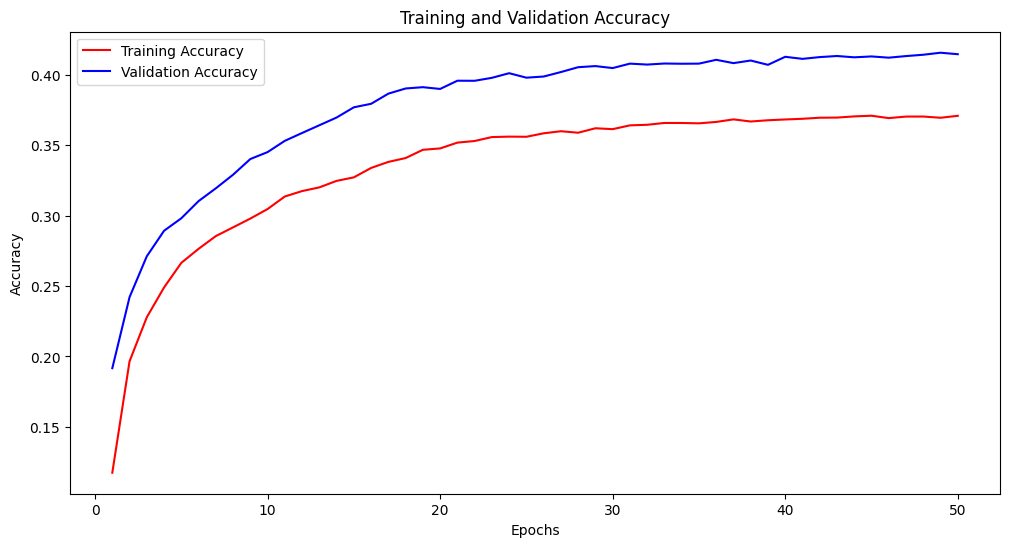

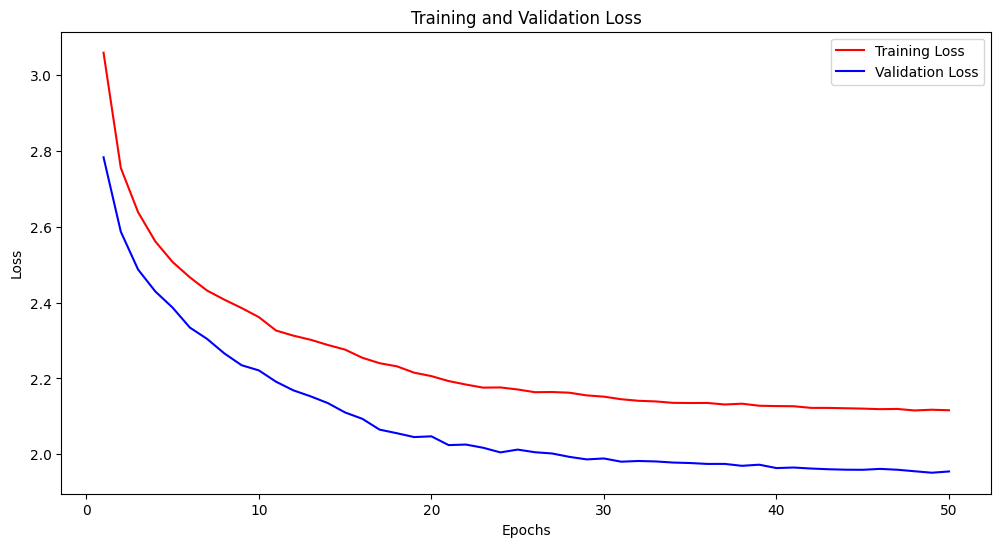

In [ ]:
# == Plot training curve ==

# Accuracy

train_accuracy = train_accuracy
val_accuracy = val_accuracy
epochs_range = range(1, len(train_accuracy) + 1)
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, train_accuracy, "r", label="Training Accuracy")
plt.plot(epochs_range, val_accuracy, "b", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(
    "Training_accuracy_"+str(NUM_CLASSES)+"classes.png",
    dpi=300,
    format="png",
    bbox_inches="tight",
)
plt.show()
plt.close()

# Loss

train_loss = train_loss
val_loss = val_loss
epochs_range = range(1, len(train_loss) + 1)
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, train_loss, "r", label="Training Loss")
plt.plot(epochs_range, val_loss, "b", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig(
    "Training_loss_"+str(NUM_CLASSES)+"classes.png",
    dpi=300,
    format="png",
    bbox_inches="tight",
)
plt.show()
plt.close()

In [ ]:
# == Test model on testset ==

pred_prob = model.predict(X_test)
pred = np.argmax(pred_prob, axis=-1)
print(f"Accuracy testset: {accuracy_score(Y_test, pred)}")

pred_prob_balanced = model.predict(X_test_balanced)
pred_balanced = np.argmax(pred_prob_balanced, axis=-1)
print(f"Accuracy testset balanced: {accuracy_score(Y_test_balanced, pred_balanced)}")

1166/1166 [==============================] - 8s 6ms/step
Accuracy testset: 0.2976532117473515
81/81 [==============================] - 1s 6ms/step
Accuracy testset balanced: 0.278189621537261


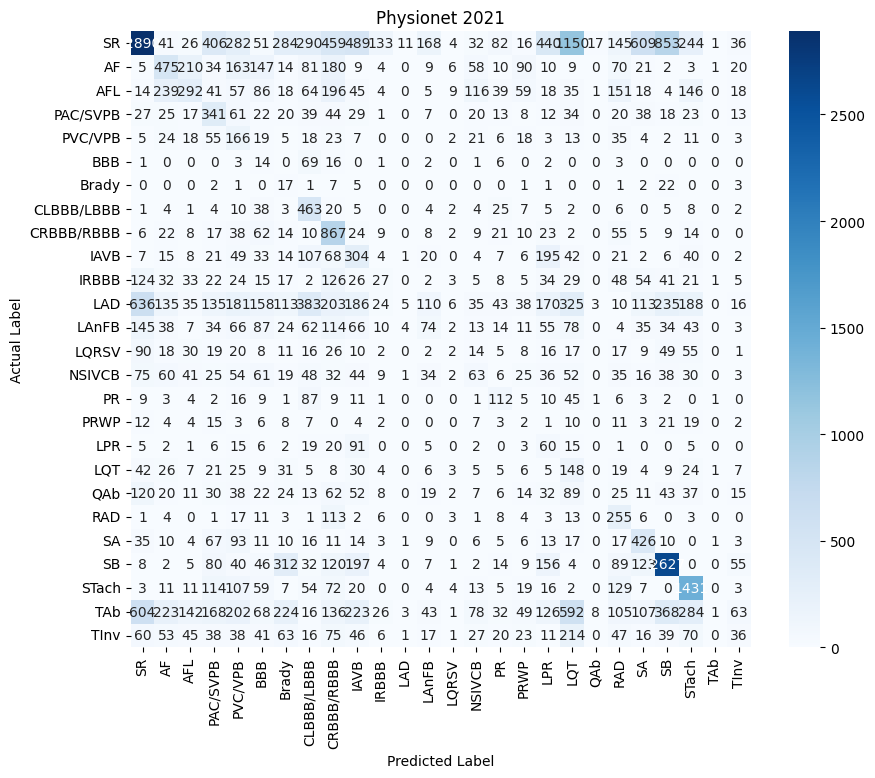

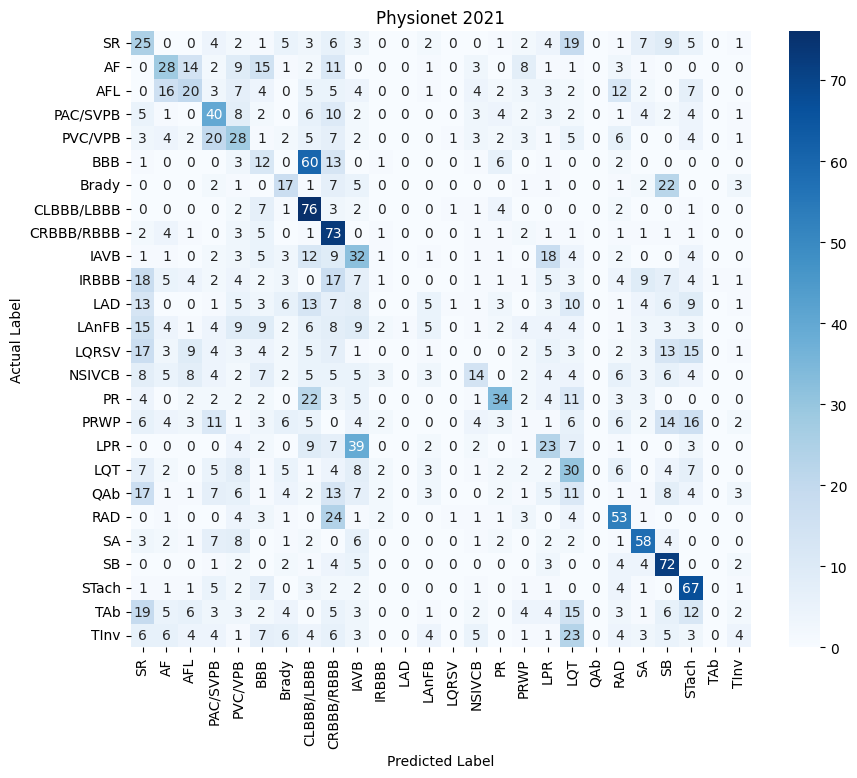

In [ ]:
# == Confusion matrix ==

if NUM_CLASSES == 26:
    labels = [
        "SR",  # sinus rhythm
        "AF",  # atrial fibrillation
        "AFL",  # atrial flutter
        "PAC/SVPB",  # premature atrial contraction / supraventricular premature beats
        "PVC/VPB",  # premature ventricular contractions / ventricular premature beats
        "BBB",  # bundle branch block
        "Brady",  # bradycardia
        "CLBBB/LBBB",  # complete left bundle branch block / left bundle branch block
        "CRBBB/RBBB",  # complete right bundle branch block / right bundle branch block
        "IAVB",  # 1st degree AV block
        "IRBBB",  # incomplete right bundle branch block
        "LAD",  # left axis deviation
        "LAnFB",  # left anterior fascicular block
        "LQRSV",  # low QRS voltages
        "NSIVCB",  # nonspecific intraventricular conduction disorder
        "PR",  # pacing rhythm
        "PRWP",  # poor R wave progression
        "LPR",  # prolonged PR interval
        "LQT",  # prolonged QT interval
        "QAb",  # Q wave abnormal
        "RAD",  # right axis deviation
        "SA",  # sinus arrhythmia
        "SB",  # sinus bradycardia
        "STach",  # sinus tachycardia
        "TAb",  # T wave abnormal
        "TInv"  # T wave inversion
    ]
else:
    labels = [
        "SR",  # sinus rhythm
        "AF",  # atrial fibrillation
        "AFL",  # atrial flutter
        "PAC/SVPB",  # premature atrial contraction / supraventricular premature beats
        "PVC/VPB",  # premature ventricular contractions / ventricular premature beats
    ]

plt.figure(figsize=(10, 8))
cm = confusion_matrix(Y_test, pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.title('Physionet 2021')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.savefig(f"ConfusionMatrix_unbalanced_{NUM_CLASSES}classes.png")
plt.show()

plt.figure(figsize=(10, 8))
cm = confusion_matrix(Y_test_balanced, pred_balanced)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.title('Physionet 2021')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.savefig(f"ConfusionMatrix_balanced_{NUM_CLASSES}classes.png")
plt.show()